# 03 — Feature Engineering

Create and explore **derived features** from the master dataset.  
No modeling yet — just feature construction and analysis.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import DATA_PROCESSED, FIGURES

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(DATA_PROCESSED / 'master_dataset.csv', index_col='Date', parse_dates=True)
df = df.dropna(subset=['target'])
df['target'] = df['target'].astype(int)
print(f"Shape: {df.shape}")

Shape: (3935, 52)


## 1. Lagged Returns

In [3]:
df['return_1d'] = df['Close'].pct_change(1)
df['return_2d'] = df['Close'].pct_change(2)
df['return_5d'] = df['Close'].pct_change(5)
df['return_10d'] = df['Close'].pct_change(10)

# Lagged returns (use yesterday's return as a feature for today's prediction)
df['return_1d_lag1'] = df['return_1d'].shift(1)
df['return_1d_lag2'] = df['return_1d'].shift(2)
df['return_1d_lag5'] = df['return_1d'].shift(5)

## 2. Moving Average Crossover Signals

In [4]:
# Price relative to moving averages
for sma_col in ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50']:
    if sma_col in df.columns:
        df[f'close_over_{sma_col}'] = (df['Close'] / df[sma_col]) - 1

# Golden/death cross: SMA_5 vs SMA_20
if 'SMA_5' in df.columns and 'SMA_20' in df.columns:
    df['sma5_above_sma20'] = (df['SMA_5'] > df['SMA_20']).astype(int)
    # Crossover event (0→1 or 1→0)
    df['sma_crossover'] = df['sma5_above_sma20'].diff().abs()

# EMA crossover
if 'EMA_12' in df.columns and 'EMA_26' in df.columns:
    df['ema12_above_ema26'] = (df['EMA_12'] > df['EMA_26']).astype(int)

## 3. RSI Zones & Momentum

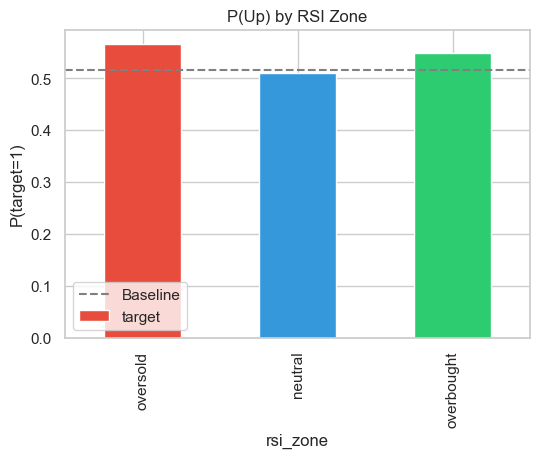

In [5]:
rsi_col = [c for c in df.columns if 'RSI' in c]
if rsi_col:
    rsi = rsi_col[0]
    df['rsi_zone'] = pd.cut(df[rsi], bins=[0, 30, 70, 100],
                            labels=['oversold', 'neutral', 'overbought'])
    df['rsi_change'] = df[rsi].diff()

    # Visualize target rate by RSI zone
    zone_rates = df.groupby('rsi_zone', observed=True)['target'].mean()
    fig, ax = plt.subplots(figsize=(6, 4))
    zone_rates.plot.bar(ax=ax, color=['#e74c3c', '#3498db', '#2ecc71'])
    ax.axhline(df['target'].mean(), ls='--', color='gray', label='Baseline')
    ax.set_title('P(Up) by RSI Zone')
    ax.set_ylabel('P(target=1)')
    ax.legend()
    plt.show()

## 4. Volume Features

In [6]:
df['volume_sma20'] = df['Volume'].rolling(20).mean()
df['volume_ratio'] = df['Volume'] / df['volume_sma20']  # >1 = above-average volume
df['volume_change'] = df['Volume'].pct_change()

# High volume days vs target
df['high_volume'] = (df['volume_ratio'] > 1.5).astype(int)
print(f"P(Up | high volume) = {df.loc[df['high_volume']==1, 'target'].mean():.3f}")
print(f"P(Up | normal volume) = {df.loc[df['high_volume']==0, 'target'].mean():.3f}")

P(Up | high volume) = 0.528
P(Up | normal volume) = 0.514


## 5. Bollinger Band Features

In [7]:
bbu = [c for c in df.columns if 'BBU' in c]
bbl = [c for c in df.columns if 'BBL' in c]
bbm = [c for c in df.columns if 'BBM' in c]

if bbu and bbl:
    bb_width = df[bbu[0]] - df[bbl[0]]
    df['bb_width'] = bb_width
    df['bb_pct'] = (df['Close'] - df[bbl[0]]) / bb_width  # 0=lower band, 1=upper band
    
    # Near bands
    df['near_upper_bb'] = (df['bb_pct'] > 0.95).astype(int)
    df['near_lower_bb'] = (df['bb_pct'] < 0.05).astype(int)
    
    print(f"P(Up | near upper BB) = {df.loc[df['near_upper_bb']==1, 'target'].mean():.3f}")
    print(f"P(Up | near lower BB) = {df.loc[df['near_lower_bb']==1, 'target'].mean():.3f}")

P(Up | near upper BB) = 0.558
P(Up | near lower BB) = 0.520


## 6. Calendar Features

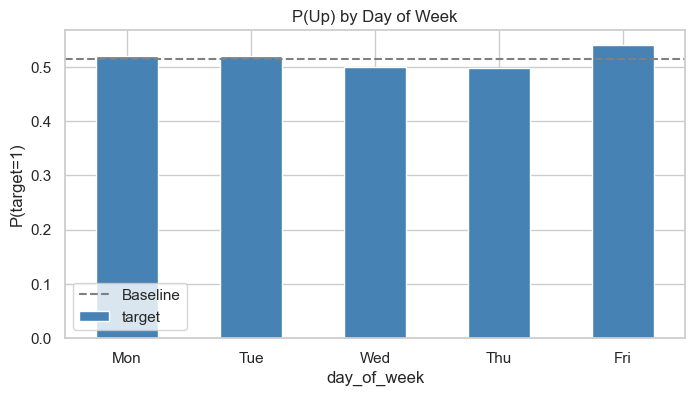

In [8]:
df['day_of_week'] = df.index.dayofweek  # 0=Mon, 4=Fri
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# Day-of-week effect
dow_rates = df.groupby('day_of_week')['target'].mean()
fig, ax = plt.subplots(figsize=(8, 4))
dow_rates.plot.bar(ax=ax, color='steelblue')
ax.axhline(df['target'].mean(), ls='--', color='gray', label='Baseline')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], rotation=0)
ax.set_title('P(Up) by Day of Week')
ax.set_ylabel('P(target=1)')
ax.legend()
plt.show()

## 7. Tweet Word Score Features

A log-odds differential word analysis of Elon Musk's tweets found that his word choice across ALL tweets predicts TSLA direction.  
Each tweet day is scored by how strongly its vocabulary skews toward statistically bullish or bearish words:
- **Bullish words** (calm/intellectual: "feel", "often", "details") → P(Up) = 0.797 next day  
- **Bearish words** (political/crisis: "government", "fired", "dei") → P(Up) = 0.418 next day  
- **Return spread**: +2.13% (bullish days avg +2.03%, bearish days avg -0.11%)

Features: raw word score, rolling averages, has-tweet flag, Tesla tweet flag.

In [9]:
tweet_cols = [c for c in df.columns if c.startswith('tweet_')]
if tweet_cols and 'tweet_word_score' in df.columns:
    # Rolling averages of word score
    df['tweet_score_sma3'] = df['tweet_word_score'].rolling(3).mean()
    df['tweet_score_sma7'] = df['tweet_word_score'].rolling(7).mean()
    df['tweet_score_change'] = df['tweet_word_score'].diff()

    # Tweet activity features
    df['tweet_count_sma7'] = df['tweet_count'].rolling(7).mean()
    df['tweet_surge'] = (df['tweet_count'] > df['tweet_count_sma7'] * 2).astype(int)

    # Interaction: word score on days with Tesla tweets
    if 'has_tesla_tweet' in df.columns:
        df['tweet_score_x_tesla'] = df['tweet_word_score'] * df['has_tesla_tweet']

    print("Tweet word score features created.")
    new_tweet = [c for c in df.columns if c.startswith('tweet_') and c not in tweet_cols]
    for c in sorted(new_tweet):
        print(f"  {c}")
else:
    print("No tweet word score data — skipping.")

Tweet word score features created.
  tweet_count_sma7
  tweet_score_change
  tweet_score_sma3
  tweet_score_sma7
  tweet_score_x_tesla
  tweet_surge


## 8. Google Trends Features (Categorized Signals)

With 13 categorized Google Trends signals (risk, investor, product, brand), we engineer:
- **Category aggregates**: total search interest per category (risk_total, investor_total, product_total)
- **Week-over-week changes**: momentum in search interest
- **Risk/investor ratio**: relative fear vs greed signal

In [10]:
gt_cols = [c for c in df.columns if c.startswith('gtrend_')]
if gt_cols:
    # --- Category aggregates ---
    risk_cols = [c for c in gt_cols if 'risk_' in c]
    inv_cols = [c for c in gt_cols if 'investor_' in c]
    prod_cols = [c for c in gt_cols if 'product_' in c]

    if risk_cols:
        df['gtrend_risk_total'] = df[risk_cols].sum(axis=1)
    if inv_cols:
        df['gtrend_investor_total'] = df[inv_cols].sum(axis=1)
    if prod_cols:
        df['gtrend_product_total'] = df[prod_cols].sum(axis=1)

    # --- Week-over-week changes for aggregates (use diff instead of pct_change to avoid inf) ---
    for agg_col in ['gtrend_risk_total', 'gtrend_investor_total', 'gtrend_product_total']:
        if agg_col in df.columns:
            df[f'{agg_col}_change'] = df[agg_col].diff()

    # Brand baseline change
    if 'gtrend_tesla' in gt_cols:
        df['gtrend_tesla_change'] = df['gtrend_tesla'].diff()

    # --- Risk/investor ratio (fear vs greed) ---
    if 'gtrend_risk_total' in df.columns and 'gtrend_investor_total' in df.columns:
        df['gtrend_risk_investor_ratio'] = (
            df['gtrend_risk_total'] / df['gtrend_investor_total'].clip(lower=1)
        )

    new_gt = [c for c in df.columns if c.startswith('gtrend_') and c not in gt_cols]
    print(f"Created {len(new_gt)} Google Trends derived features:")
    for c in sorted(new_gt):
        print(f"  {c}")
else:
    print("No Google Trends data — skipping.")

Created 8 Google Trends derived features:
  gtrend_investor_total
  gtrend_investor_total_change
  gtrend_product_total
  gtrend_product_total_change
  gtrend_risk_investor_ratio
  gtrend_risk_total
  gtrend_risk_total_change
  gtrend_tesla_change


## 9. SEC Filing Signals

Integrate LLM-classified SEC filing signals (10-K MD&A, 8-K events, Shareholder Letters) into the feature set.  
Each filing was preprocessed and classified by Qwen 2.5 7B into an **impact score** (-5 to +5), **materiality**, and **topic** from an investor perspective.

In [11]:
from src.helpers import DATA_RAW

sec = pd.read_csv(DATA_RAW / 'sec_daily_signals.csv', parse_dates=['date'])

# --- Encode materiality as ordinal ---
MATERIALITY_MAP = {'procedural': 0, 'low': 1, 'medium': 2, 'high': 3}
sec['materiality_ord'] = sec['materiality'].map(MATERIALITY_MAP)

# --- Aggregate to one row per date (multiple filings possible) ---
daily = sec.groupby('date').agg(
    sec_impact       = ('impact_score', 'mean'),     # average impact across sections
    sec_impact_max   = ('impact_score', 'max'),      # strongest signal
    sec_impact_min   = ('impact_score', 'min'),      # most negative signal
    sec_materiality  = ('materiality_ord', 'max'),   # highest materiality
    sec_filing_count = ('impact_score', 'count'),    # number of classified sections
    sec_length_delta = ('length_delta_pct', 'mean'),
).rename_axis('Date')

# Pick dominant topic from highest-materiality row each day
idx_max_mat = sec.groupby('date')['materiality_ord'].idxmax()
daily['sec_topic'] = sec.loc[idx_max_mat].set_index('date')['topic']
daily.index.name = 'Date'

# --- Merge into main df ---
df = df.join(daily, how='left')

# Filing day flag
df['sec_filing_day'] = df['sec_impact'].notna().astype(int)

# Forward-fill SEC signals (persist until next filing)
ffill_cols = ['sec_impact', 'sec_impact_max', 'sec_impact_min',
              'sec_materiality', 'sec_filing_count', 'sec_length_delta']
df[ffill_cols] = df[ffill_cols].ffill()

# Days since last filing (decaying signal)
filing_dates = df.index[df['sec_filing_day'] == 1]
df['sec_days_since_filing'] = np.nan
for fd in filing_dates:
    mask = df.index >= fd
    df.loc[mask, 'sec_days_since_filing'] = (df.index[mask] - fd).days

# One-hot encode dominant topic
if 'sec_topic' in df.columns:
    df['sec_topic'] = df['sec_topic'].ffill()
    topic_dummies = pd.get_dummies(df['sec_topic'], prefix='sec_topic')
    df = pd.concat([df.drop(columns=['sec_topic']), topic_dummies], axis=1)

print(f"SEC features merged. Shape: {df.shape}")
print(f"Filing days in dataset: {int(df['sec_filing_day'].sum())}")
sec_cols = [c for c in df.columns if c.startswith('sec_')]
print(f"SEC columns ({len(sec_cols)}): {sec_cols}")
print(f"\nImpact score stats (forward-filled):")
print(df['sec_impact'].describe().round(3))

SEC features merged. Shape: (3935, 109)
Filing days in dataset: 161
SEC columns (16): ['sec_impact', 'sec_impact_max', 'sec_impact_min', 'sec_materiality', 'sec_filing_count', 'sec_length_delta', 'sec_filing_day', 'sec_days_since_filing', 'sec_topic_deal', 'sec_topic_earnings', 'sec_topic_guidance', 'sec_topic_legal', 'sec_topic_other', 'sec_topic_personnel', 'sec_topic_product', 'sec_topic_production']

Impact score stats (forward-filled):
count    2547.000
mean        0.676
std         0.852
min        -1.500
25%         0.000
50%         0.000
75%         1.000
max         4.000
Name: sec_impact, dtype: float64


## 10. Final Correlation Check

Compute correlations between all newly engineered features and the target variable.  
This provides a quick sanity check that the features carry signal, and surfaces any features with unexpectedly strong or weak associations before we proceed to multicollinearity cleanup.

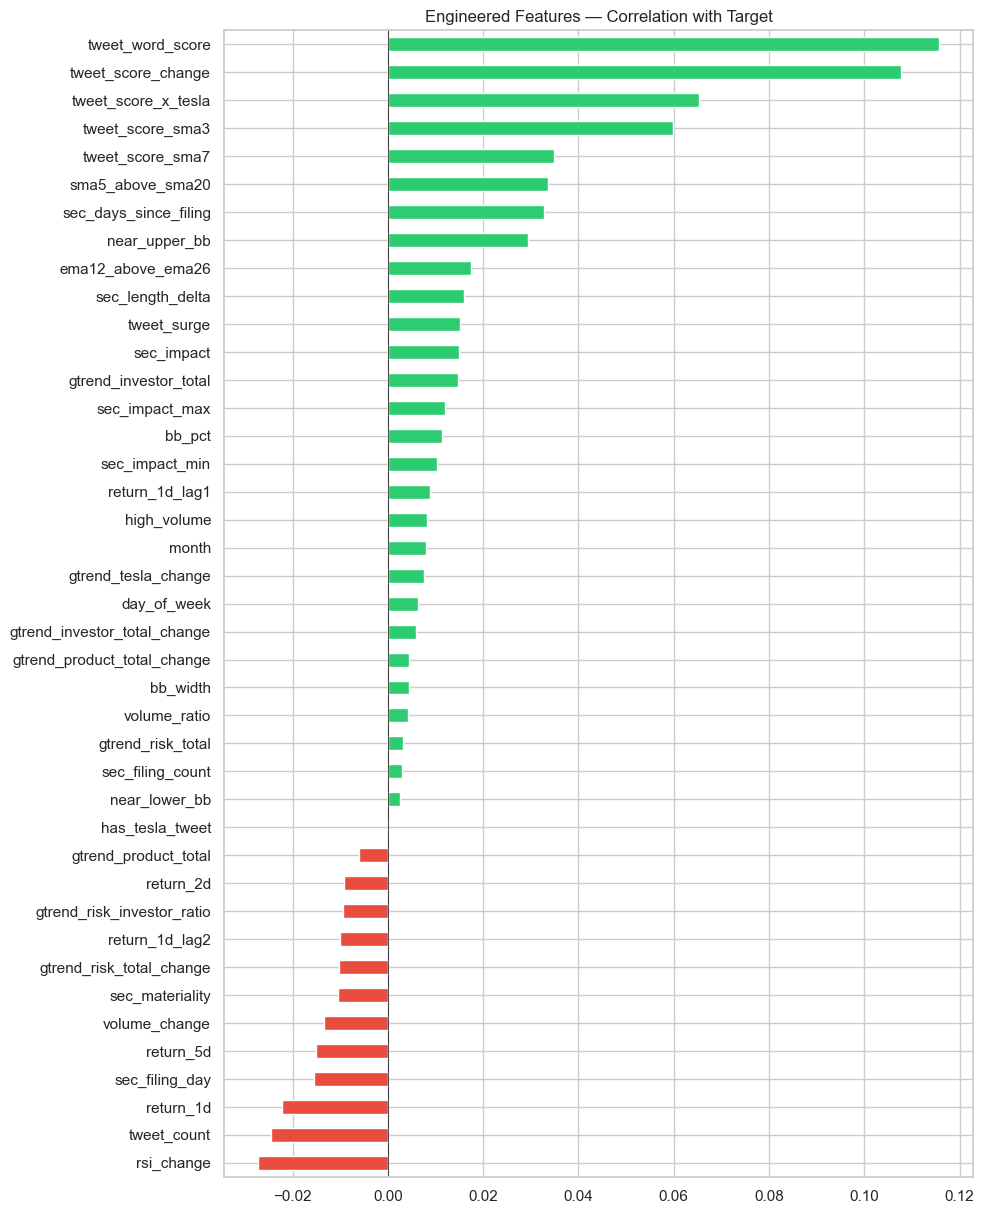


Top correlated engineered features:
tweet_word_score         0.115662
tweet_score_change       0.107783
tweet_score_x_tesla      0.065374
tweet_score_sma3         0.059895
tweet_score_sma7         0.034943
sma5_above_sma20         0.033545
sec_days_since_filing    0.032863
near_upper_bb            0.029368
rsi_change               0.027185
tweet_count              0.024452
return_1d                0.022272
ema12_above_ema26        0.017448
sec_length_delta         0.015955
sec_filing_day           0.015444
tweet_surge              0.015060
Name: target, dtype: float64


In [12]:
# New features only
new_feats = ['return_1d', 'return_2d', 'return_5d', 'return_1d_lag1', 'return_1d_lag2',
             'volume_ratio', 'volume_change', 'high_volume',
             'bb_pct', 'bb_width', 'near_upper_bb', 'near_lower_bb',
             'day_of_week', 'month',
             'rsi_change', 'sma5_above_sma20', 'ema12_above_ema26']
new_feats = [c for c in new_feats if c in df.columns]

# Add tweet word score features
new_feats += [c for c in ['tweet_word_score', 'tweet_score_sma3', 'tweet_score_sma7',
                           'tweet_score_change', 'tweet_surge', 'tweet_score_x_tesla',
                           'tweet_count', 'has_tesla_tweet'] if c in df.columns]

# Add Google Trends aggregate features
new_feats += [c for c in ['gtrend_risk_total', 'gtrend_investor_total', 'gtrend_product_total',
                           'gtrend_risk_total_change', 'gtrend_investor_total_change',
                           'gtrend_product_total_change', 'gtrend_tesla_change',
                           'gtrend_risk_investor_ratio'] if c in df.columns]

# Add SEC features
new_feats += [c for c in ['sec_impact', 'sec_impact_max', 'sec_impact_min',
                           'sec_materiality', 'sec_filing_day',
                           'sec_days_since_filing', 'sec_filing_count',
                           'sec_length_delta'] if c in df.columns]

corr = df[new_feats + ['target']].corr()['target'].drop('target').sort_values()

fig, ax = plt.subplots(figsize=(10, max(5, len(corr)*0.3)))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in corr]
corr.plot.barh(ax=ax, color=colors)
ax.set_title('Engineered Features — Correlation with Target')
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nTop correlated engineered features:")
print(corr.abs().sort_values(ascending=False).head(15))

## 11. Multicollinearity Cleanup

With 94 numeric features, many are near-duplicates (71 pairs with |r| > 0.90).  
Redundant features waste model capacity and inflate variance without adding signal.

**Strategy**: for each cluster of correlated features, keep the most informative one and drop the rest.

| Cluster | Keep | Drop | Reason |
|---------|------|------|--------|
| Price-level (9 raw SMA/EMA/BB) | `close_over_SMA_*`, `bb_pct`, crossover flags | Raw SMA, EMA, BB levels | Absolute price has no predictive meaning; ratios do |
| Bollinger duplicate | `bb_pct` | `BBP_20_2.0_2.0` | Exact duplicate (r=1.000) |
| MACD | `MACDh_12_26_9` (histogram) | `MACD_12_26_9`, `MACDs_12_26_9` | Histogram = MACD − signal, captures crossovers |
| Stochastic | `STOCHk_14_3_3` | `STOCHd_14_3_3` | %D is just smoothed %K (r=0.961) |
| Returns ↔ SMA ratios | `close_over_SMA_*` | `return_2d/5d/10d` | SMA ratios encode the same info more stably |
| Calendar | `month` | `quarter` | Month is finer-grained (r=0.971) |
| Tweet | `tweet_word_score`, `tweet_score_sma7`, `tweet_surge`, `has_tesla_tweet` | `tweet_bull/bear_count`, `tweet_count`, `sma3`, `count_sma7`, `score_change`, `tesla_tweet_count`, `score_x_tesla` | bear_count ↔ word_score r=−0.996; sma3 ↔ sma7 r=0.912 |
| Google Trends | Category totals + changes + `gtrend_tesla` | Individual sub-terms | Sub-terms dominated by totals (r>0.92) |
| SEC | `sec_impact`, `sec_filing_day`, `sec_days_since_filing`, `sec_materiality`, `sec_length_delta` | `sec_impact_max/min`, `sec_filing_count` | max ↔ mean r=0.909; length_delta kept (orthogonal, corr=-0.11 with target) |
| Financials | `eps_diluted`, `quarterly_revenue` | `net_income`, `OBV` | eps ↔ net_income r=0.990; OBV ↔ revenue r=0.926 |
| Volatility | `volatility_20` | `ATRr_14` | ATR tracks price level (r>0.93 with SMAs) |

In [13]:
n_before = df.shape[1]

# --- Build drop list ---
drop_redundant = []

# 1. Raw price-level features (keep relative versions: close_over_SMA_*, bb_pct, crossover flags)
drop_redundant += ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26',
                   'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0']

# 2. Exact Bollinger duplicate
drop_redundant += ['BBP_20_2.0_2.0']

# 3. MACD: keep histogram only
drop_redundant += ['MACD_12_26_9', 'MACDs_12_26_9']

# 4. Stochastic: keep %K only
drop_redundant += ['STOCHd_14_3_3']

# 5. Multi-day returns (redundant with close_over_SMA_*)
drop_redundant += ['return_2d', 'return_5d', 'return_10d']

# 6. Calendar: quarter is redundant with month
drop_redundant += ['quarter']

# 7. Tweet: keep word_score, score_sma7, tweet_surge, has_tesla_tweet
drop_redundant += ['tweet_bull_count', 'tweet_bear_count', 'tweet_count',
                   'tweet_score_sma3', 'tweet_count_sma7', 'tweet_score_change',
                   'tesla_tweet_count', 'tweet_score_x_tesla']

# 8. Google Trends: keep totals + changes + tesla baseline, drop individual sub-terms
gt_individual = [c for c in df.columns if c.startswith('gtrend_') and any(
    sub in c for sub in ['risk_', 'investor_', 'product_']
) and '_total' not in c and '_change' not in c]
drop_redundant += gt_individual

# 9. SEC: keep impact mean, filing_day, days_since_filing, materiality + topics
drop_redundant += ['sec_impact_max', 'sec_impact_min', 'sec_filing_count']

# 10. Financials: keep eps_diluted, quarterly_revenue
drop_redundant += ['net_income', 'OBV']

# 11. ATR tracks price level — keep volatility_20
drop_redundant += ['ATRr_14']

# --- Drop ---
drop_redundant = [c for c in drop_redundant if c in df.columns]
df = df.drop(columns=drop_redundant)

print(f"Dropped {len(drop_redundant)} redundant features: {n_before} → {df.shape[1]} columns")
print(f"\nDropped columns:")
for c in sorted(drop_redundant):
    print(f"  {c}")

# --- Verify: check remaining high correlations ---
exclude = ['Open', 'High', 'Low', 'Close', 'Volume', 'target']
feat_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]
corr = df[feat_cols].corr()

remaining_high = []
for i in range(len(feat_cols)):
    for j in range(i+1, len(feat_cols)):
        r = corr.iloc[i, j]
        if abs(r) > 0.90:
            remaining_high.append((feat_cols[i], feat_cols[j], round(r, 4)))

remaining_high.sort(key=lambda x: -abs(x[2]))
print(f"\nRemaining pairs with |r| > 0.90: {len(remaining_high)}")
for a, b, r in remaining_high:
    print(f"  {r:+.4f}  {a:35s} ↔ {b}")

Dropped 44 redundant features: 109 → 65 columns

Dropped columns:
  ATRr_14
  BBL_20_2.0_2.0
  BBM_20_2.0_2.0
  BBP_20_2.0_2.0
  BBU_20_2.0_2.0
  EMA_12
  EMA_26
  MACD_12_26_9
  MACDs_12_26_9
  OBV
  SMA_10
  SMA_20
  SMA_5
  SMA_50
  STOCHd_14_3_3
  gtrend_investor_buy_tesla_stock
  gtrend_investor_sell_tesla_stock
  gtrend_investor_tesla_stock_price
  gtrend_investor_tsla_earnings
  gtrend_product_cybertruck_delivery
  gtrend_product_tesla_fsd
  gtrend_product_tesla_model_2
  gtrend_product_tesla_robotaxi
  gtrend_risk_investor_ratio
  gtrend_risk_tesla_crash
  gtrend_risk_tesla_investigation
  gtrend_risk_tesla_lawsuit
  gtrend_risk_tesla_recall
  net_income
  quarter
  return_10d
  return_2d
  return_5d
  sec_filing_count
  sec_impact_max
  sec_impact_min
  tesla_tweet_count
  tweet_bear_count
  tweet_bull_count
  tweet_count
  tweet_count_sma7
  tweet_score_change
  tweet_score_sma3
  tweet_score_x_tesla

Remaining pairs with |r| > 0.90: 1
  +0.9020  return_1d                    

## 12. Feature Selection — Keep Only What Matters

After removing redundant features, we still have ~58 numeric features for ~2,000 training rows.  
Many of these add noise without predictive value. Strategy:

1. **Mutual Information** — non-linear association with target (model-agnostic)
2. **XGBoost importance** — tree-based feature ranking
3. **Combine both** rankings → keep top 25 features
4. **Drop the rest** — less noise, better generalization

**Important:** Feature selection is performed on **training data only** (pre-2024) to avoid leakage. The selected feature set is then applied to the full dataset.

Feature selection using training data only: 1950 rows (< 2024-01-01)


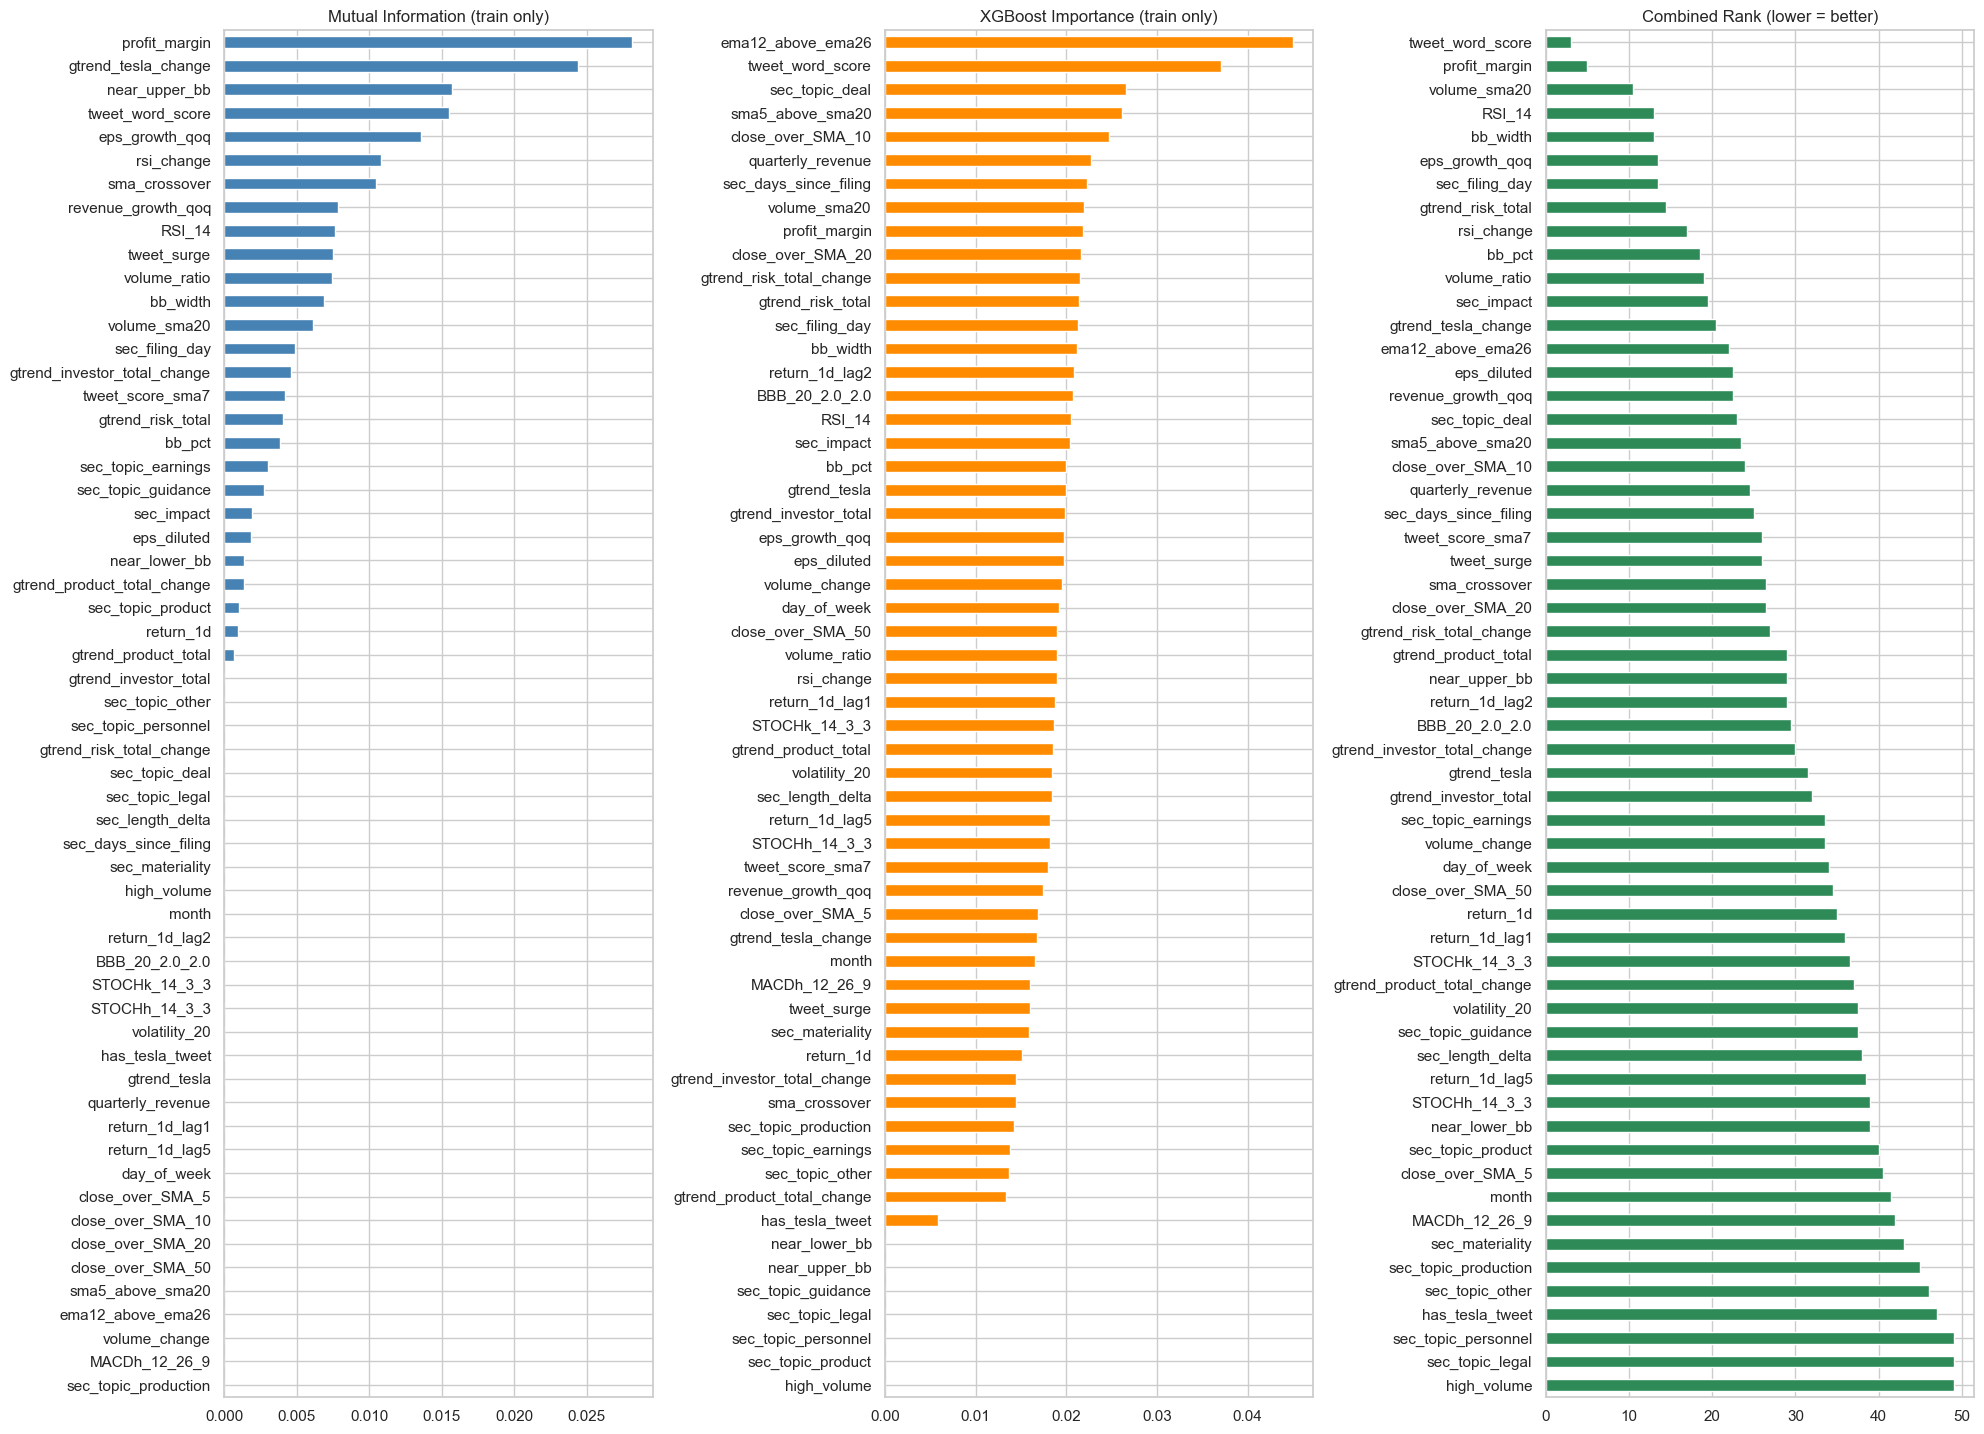


Top 25 features by combined rank (from training data only):
   1. tweet_word_score                     MI=0.0155  XGB=0.0370  rank=3.0
   2. profit_margin                        MI=0.0282  XGB=0.0218  rank=5.0
   3. volume_sma20                         MI=0.0061  XGB=0.0219  rank=10.5
   4. RSI_14                               MI=0.0077  XGB=0.0205  rank=13.0
   5. bb_width                             MI=0.0069  XGB=0.0211  rank=13.0
   6. eps_growth_qoq                       MI=0.0136  XGB=0.0198  rank=13.5
   7. sec_filing_day                       MI=0.0048  XGB=0.0212  rank=13.5
   8. gtrend_risk_total                    MI=0.0040  XGB=0.0214  rank=14.5
   9. rsi_change                           MI=0.0108  XGB=0.0190  rank=17.0
  10. bb_pct                               MI=0.0038  XGB=0.0199  rank=18.5
  11. volume_ratio                         MI=0.0075  XGB=0.0190  rank=19.0
  12. sec_impact                           MI=0.0019  XGB=0.0204  rank=19.5
  13. gtrend_tesla_change    

In [14]:
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier

TRAIN_CUTOFF = '2024-01-01'  # feature selection on training period ONLY (no leakage)

exclude = ['Open', 'High', 'Low', 'Close', 'Volume', 'target']

# Include bool columns by casting them to int
bool_cols = [c for c in df.columns if df[c].dtype == bool]
for c in bool_cols:
    df[c] = df[c].astype(int)

feat_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

# *** LEAKAGE FIX: use ONLY training data to rank and select features ***
X_sel = df.loc[df.index < TRAIN_CUTOFF, feat_cols].dropna()
y_sel = df.loc[X_sel.index, 'target'].astype(int)
print(f'Feature selection using training data only: {len(X_sel)} rows (< {TRAIN_CUTOFF})')

# --- 1. Mutual Information ---
mi_scores = mutual_info_classif(X_sel, y_sel, random_state=42, n_neighbors=5)
mi = pd.Series(mi_scores, index=feat_cols).sort_values(ascending=False)

# --- 2. XGBoost importance ---
xgb = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05,
                     random_state=42, eval_metric='logloss')
xgb.fit(X_sel, y_sel)
xgb_imp = pd.Series(xgb.feature_importances_, index=feat_cols).sort_values(ascending=False)

# --- 3. Combined ranking ---
mi_rank = mi.rank(ascending=False)
xgb_rank = xgb_imp.rank(ascending=False)
avg_rank = ((mi_rank + xgb_rank) / 2).sort_values()

# --- Visualize ---
fig, axes = plt.subplots(1, 3, figsize=(20, max(6, len(feat_cols) * 0.25)))

mi.plot.barh(ax=axes[0], color='steelblue')
axes[0].set_title('Mutual Information (train only)')
axes[0].invert_yaxis()

xgb_imp.plot.barh(ax=axes[1], color='darkorange')
axes[1].set_title('XGBoost Importance (train only)')
axes[1].invert_yaxis()

avg_rank.plot.barh(ax=axes[2], color='seagreen')
axes[2].set_title('Combined Rank (lower = better)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print(f'\nTop 25 features by combined rank (from training data only):')
for i, (feat, rank) in enumerate(avg_rank.head(25).items(), 1):
    print(f'  {i:2d}. {feat:35s}  MI={mi[feat]:.4f}  XGB={xgb_imp[feat]:.4f}  rank={rank:.1f}')

In [15]:
# --- 4. Select top features by combined rank ---
n_keep = 25
selected_features = avg_rank.head(n_keep).index.tolist()

# Drop unselected features
meta_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'target']
all_feat_cols = [c for c in df.columns if c not in meta_cols]
drop_features = [c for c in all_feat_cols if c not in selected_features]

n_before = df.shape[1]
df = df.drop(columns=drop_features)

print(f'Feature selection: kept {n_keep} features, dropped {len(drop_features)} ({n_before} → {df.shape[1]} columns)')
print(f'\nSelected features:')
for i, feat in enumerate(selected_features, 1):
    print(f'  {i:2d}. {feat:35s}  MI={mi[feat]:.4f}  XGB={xgb_imp[feat]:.4f}  rank={avg_rank[feat]:.1f}')
print(f'\nDropped features:')
for c in sorted(drop_features):
    print(f'  {c}')

Feature selection: kept 25 features, dropped 34 (65 → 31 columns)

Selected features:
   1. tweet_word_score                     MI=0.0155  XGB=0.0370  rank=3.0
   2. profit_margin                        MI=0.0282  XGB=0.0218  rank=5.0
   3. volume_sma20                         MI=0.0061  XGB=0.0219  rank=10.5
   4. RSI_14                               MI=0.0077  XGB=0.0205  rank=13.0
   5. bb_width                             MI=0.0069  XGB=0.0211  rank=13.0
   6. eps_growth_qoq                       MI=0.0136  XGB=0.0198  rank=13.5
   7. sec_filing_day                       MI=0.0048  XGB=0.0212  rank=13.5
   8. gtrend_risk_total                    MI=0.0040  XGB=0.0214  rank=14.5
   9. rsi_change                           MI=0.0108  XGB=0.0190  rank=17.0
  10. bb_pct                               MI=0.0038  XGB=0.0199  rank=18.5
  11. volume_ratio                         MI=0.0075  XGB=0.0190  rank=19.0
  12. sec_impact                           MI=0.0019  XGB=0.0204  rank=19.5
  13

## 13. Save Final Feature Dataset

Write the cleaned, selected feature set to disk as `features_ready.csv`.  
This file is the direct input for the modeling notebooks.

In [16]:
# Drop helper columns that aren't features
drop_cols = ['rsi_zone']  # categorical, already encoded as rsi_change etc.
df_final = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Drop rows with NaN from rolling calculations (first ~50 rows)
n_before = len(df_final)
df_final = df_final.dropna()
print(f"Dropped {n_before - len(df_final)} rows with NaN (warmup period).")
print(f"Final dataset: {df_final.shape}")

df_final.to_csv(DATA_PROCESSED / 'features_ready.csv')
print(f"Saved to {DATA_PROCESSED / 'features_ready.csv'}")
print(f"\nThis dataset is ready for modeling in Part 2!")
df_final.tail()

Dropped 1389 rows with NaN (warmup period).
Final dataset: (2546, 31)
Saved to /Users/matheomenges/Desktop/tsla-direction-predictor/data/processed/features_ready.csv

This dataset is ready for modeling in Part 2!


,Open,High,Low,Close,Volume,target,RSI_14,tweet_word_score,quarterly_revenue,eps_diluted,...,bb_width,bb_pct,tweet_score_sma7,tweet_surge,gtrend_risk_total,gtrend_tesla_change,sec_impact,sec_filing_day,sec_days_since_filing,sec_topic_deal
Date,,,,,,,,,,,,,,,,,,,,,
2026-02-12,430.299988,436.230011,414.000000,417.070007,61933400,1,44.738596,-2.0,2.490100e+10,0.24,...,52.985579,0.335540,-2.0,0,6.0,0.0,0.0,0,14.0,0
2026-02-13,414.309998,424.059998,410.880005,417.440002,51434100,0,44.921018,-2.0,2.490100e+10,0.24,...,52.054133,0.360002,-2.0,0,6.0,0.0,0.0,0,15.0,0
2026-02-17,412.359985,413.720001,400.510010,410.630005,59678800,1,42.162252,-2.0,2.490100e+10,0.24,...,52.050110,0.254967,-2.0,0,6.0,-1.0,0.0,0,19.0,0
2026-02-18,411.109985,416.899994,409.579987,411.320007,45831600,0,42.547255,-2.0,2.490100e+10,0.24,...,53.054072,0.280083,-2.0,0,6.0,0.0,0.0,0,20.0,0
2026-02-19,407.333496,410.299988,404.109985,409.349915,9269167,0,41.693868,-2.0,2.490100e+10,0.24,...,53.764693,0.266890,-2.0,0,6.0,0.0,0.0,0,21.0,0
